<a href="https://www.kaggle.com/code/mikedelong/python-eda-and-binary-classifier?scriptVersionId=141838124" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/student-graduation-dataset/graduation_dataset.csv')
df['Target_int'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0, 'Enrolled': 2})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [2]:
df.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance                          2
Previous qualification                             17
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                32
Father's occupation                                46
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder                                  2
Age at enrollment                                  46
International               

<Axes: xlabel='Target'>

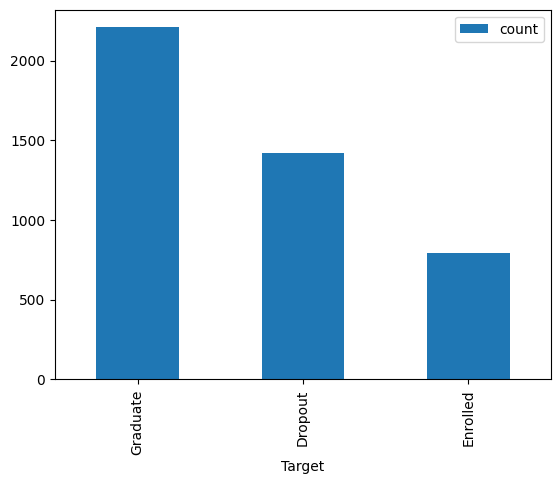

In [3]:
df['Target'].value_counts().plot(kind='bar', legend=True)

Our target variable is unbalanced and we also have a bogie class.

<Axes: >

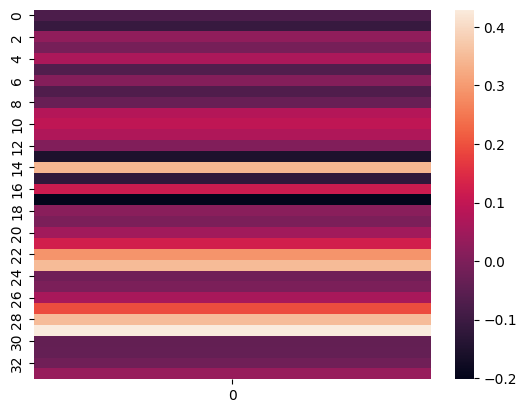

In [4]:
from seaborn import heatmap
heatmap(data=df[[column for column in df.columns.tolist() if not column.startswith('Tar')]].corrwith(axis='rows',
                                                                                                     other=df['Target_int'], ).values.reshape(df.shape[1]-2, 1))

<Axes: >

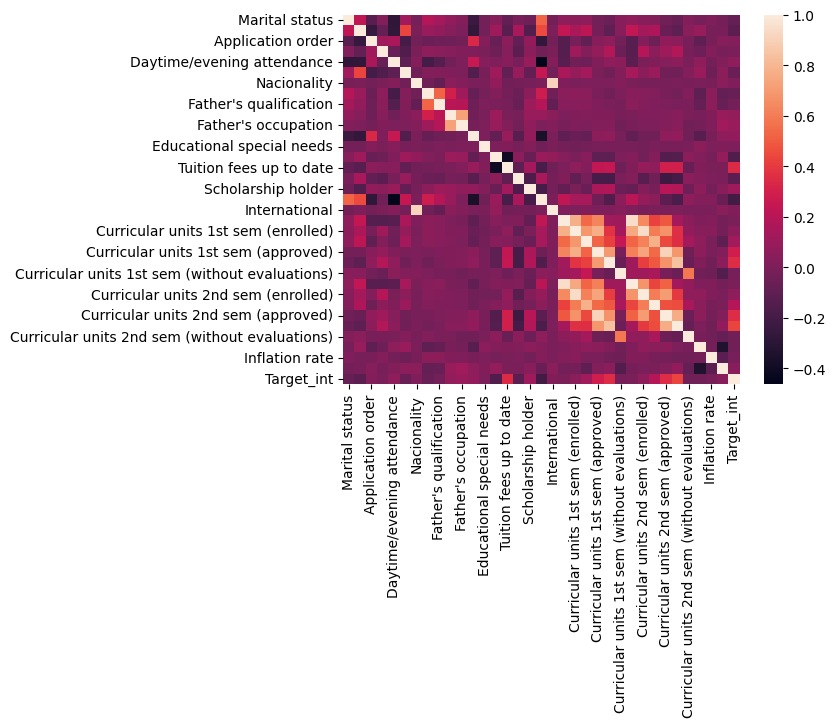

In [5]:
from seaborn import heatmap
heatmap(data=df.drop(columns=['Target']).corr())

Let's look at the correlations if we drop Target = Enrolled.

<Axes: >

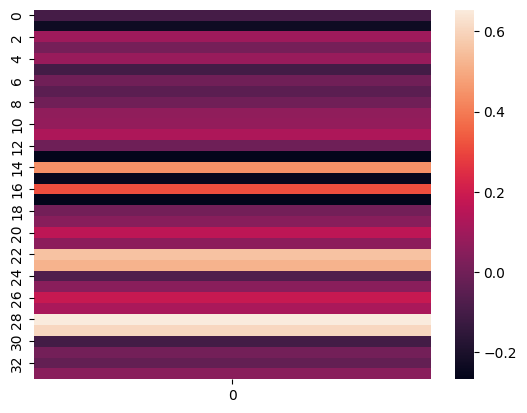

In [6]:
binary_df = df[df['Target'] != 'Enrolled']
heatmap(data=binary_df.drop(columns=['Target', 'Target_int']).corrwith(axis='rows',other=binary_df['Target_int'], ).values.reshape(binary_df.shape[1]-2, 1))

In [7]:
binary_df.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   7
Course                                             17
Daytime/evening attendance                          2
Previous qualification                             17
Nacionality                                        19
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                29
Father's occupation                                42
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder                                  2
Age at enrollment                                  46
International               

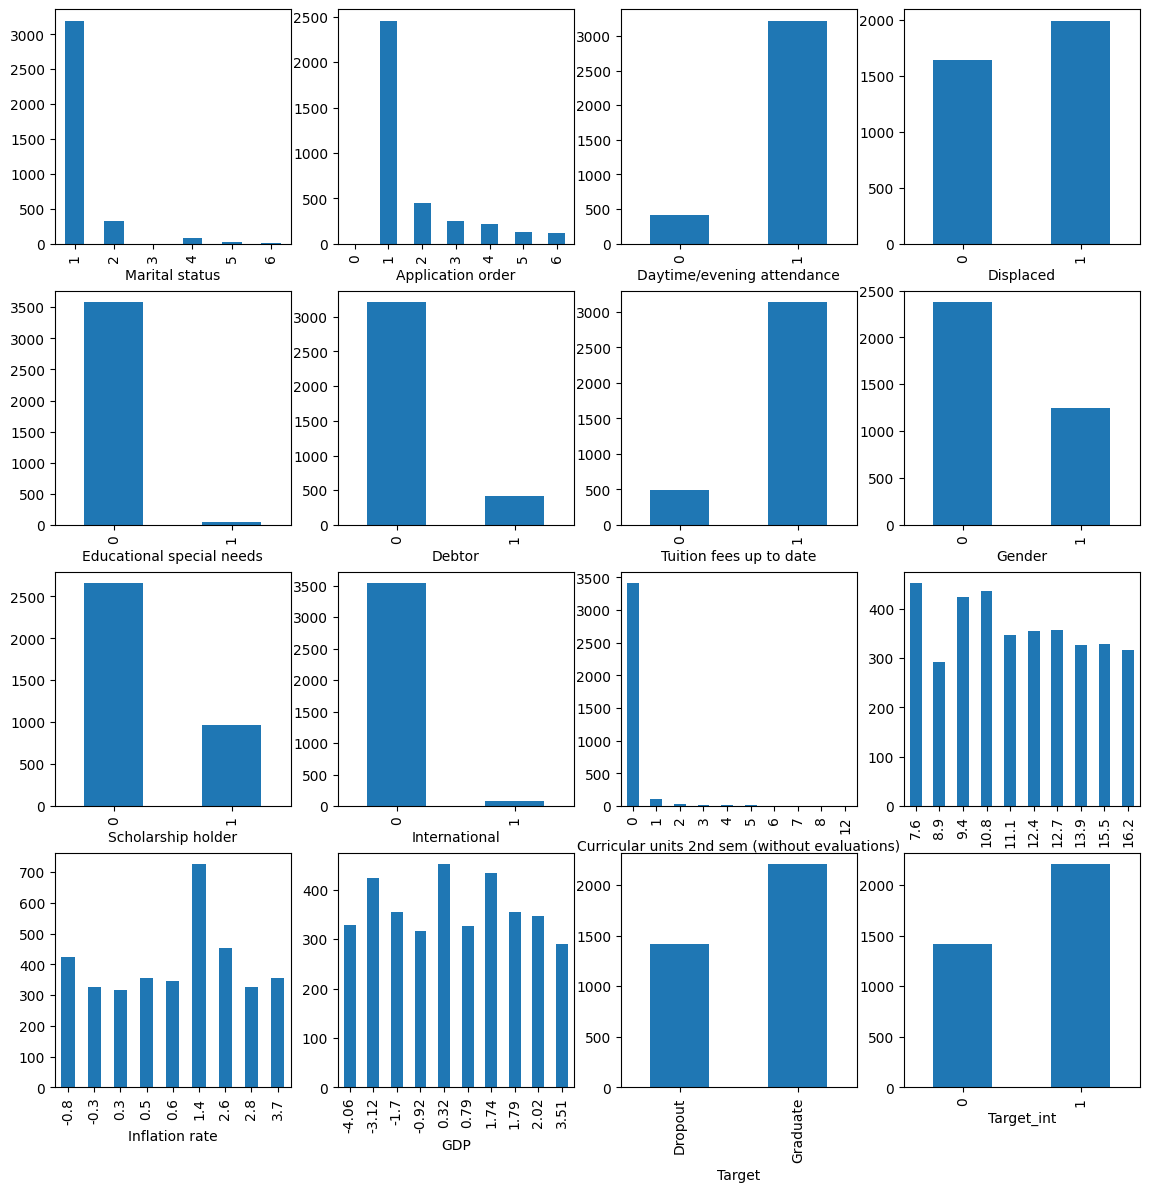

In [8]:
from matplotlib.pyplot import subplots
_, ax = subplots(figsize=(14, 14), ncols=4, nrows=4)
for index, column in enumerate([column for column, value in binary_df.nunique().items() if value < 11]):
    binary_df[column].value_counts().sort_index().plot(ax=ax.ravel()[index], kind='bar')

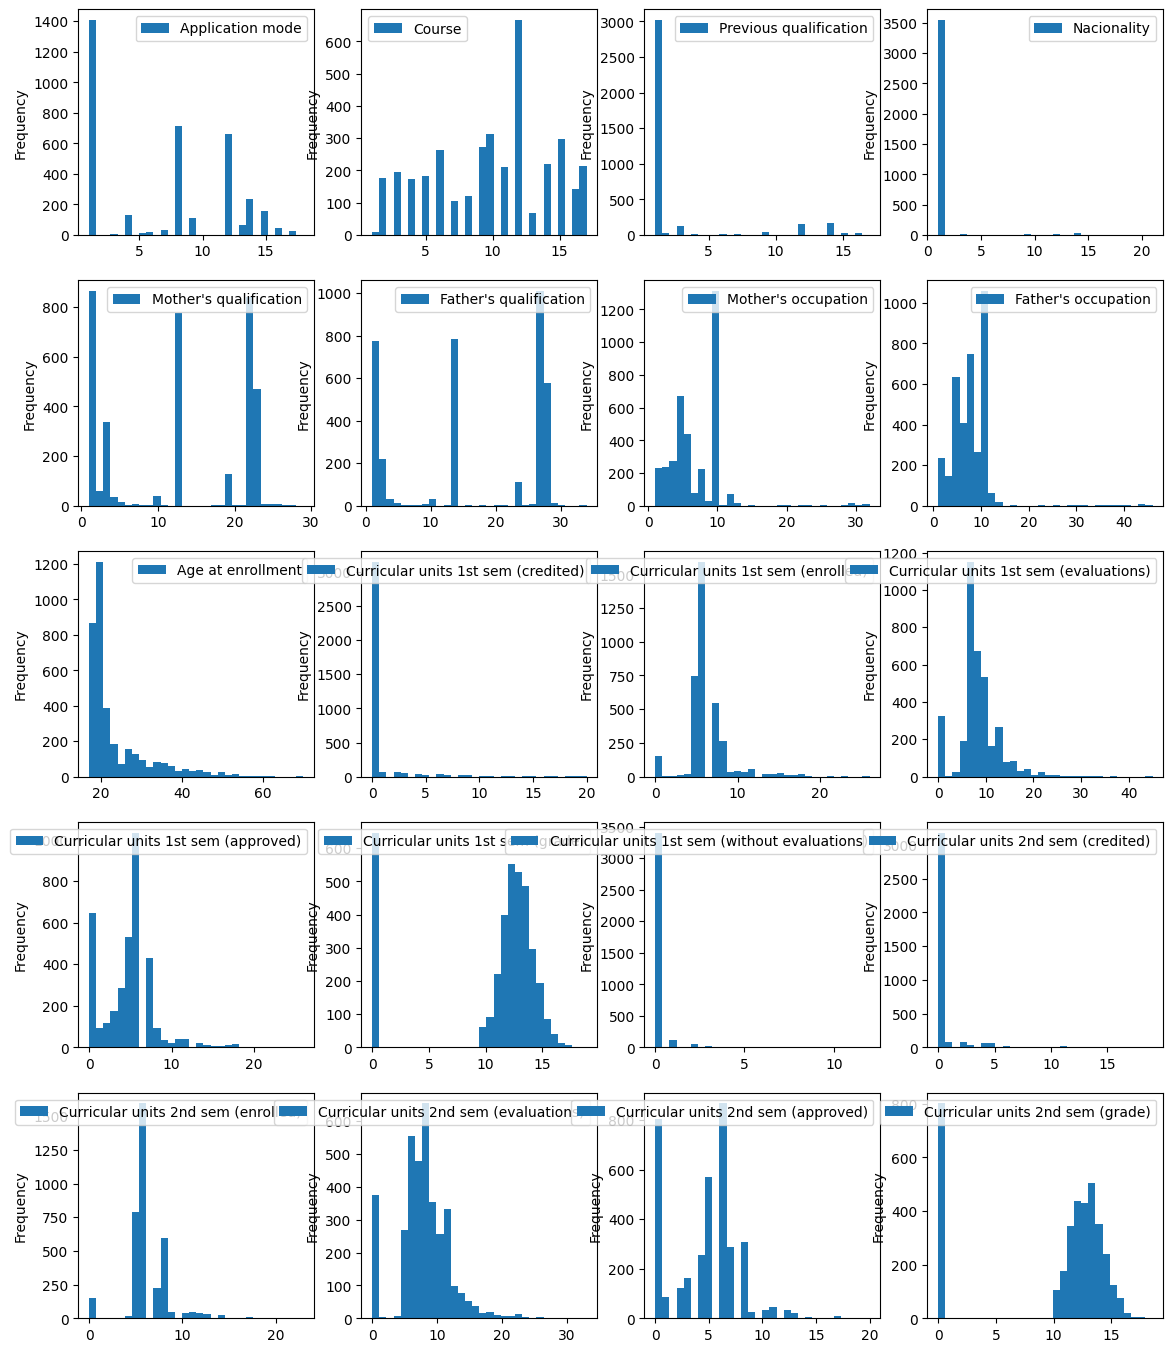

In [9]:
_, ax = subplots(figsize=(14, 17), ncols=4, nrows=5)
for index, column in enumerate([column for column, value in binary_df.nunique().items() if value >= 11]):
    binary_df[column].plot.hist(ax=ax.ravel()[index], bins=30, legend=True)

A lot of our data looks pretty sensible but we also have a lot of zeros, suggesting that we have multiple variables with mixed distributions.

In [10]:
binary_df['Target_int'].value_counts(normalize=True)

Target_int
1    0.60854
0    0.39146
Name: proportion, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(binary_df.drop(columns=['Target', 'Target_int']), binary_df['Target_int'].values,
                                                    test_size=0.33, random_state=2023, stratify=binary_df['Target_int'])
print('fractions that are 1 in train: {:6.3f} test: {:6.3f}'.format(y_train.sum()/len(y_train), y_test.sum()/len(y_test)))

fractions that are 1 in train:  0.609 test:  0.609


In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2023, verbose=1)
model.fit(X=X_train, y=y_train)
print('classes: {}'.format(model.n_classes_))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s


classes: 2


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [13]:
from sklearn.metrics import classification_report
y_pred = model.predict(X=X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       469
           1       0.90      0.95      0.93       729

    accuracy                           0.91      1198
   macro avg       0.91      0.89      0.90      1198
weighted avg       0.91      0.91      0.91      1198



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [14]:
RESULT_MAP = {0.0: 'Dropout', 1.0: 'Graduate'}
def result_state(arg):
    return RESULT_MAP[arg['expected']] + '/' + RESULT_MAP[arg['actual']]
    
test_df = X_test.copy()
test_df['expected'] = y_test
test_df['actual'] = y_pred
test_df['result'] = test_df.apply(axis=1, func=result_state)
test_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,expected,actual,result
3501,1,12,1,5,1,1,1,22,27,10,...,6,0,0.000000,0,16.2,0.3,-0.92,0,0,Dropout/Dropout
1297,1,12,1,12,1,1,1,22,27,10,...,9,5,12.380000,0,12.4,0.5,1.79,0,0,Dropout/Dropout
4362,1,1,3,6,1,1,1,1,28,10,...,7,4,12.500000,0,7.6,2.6,0.32,1,1,Graduate/Graduate
1475,1,8,1,8,1,1,1,13,28,5,...,9,5,12.600000,0,9.4,-0.8,-3.12,1,1,Graduate/Graduate
3005,1,1,4,12,1,1,1,13,28,8,...,9,8,14.955556,0,12.4,0.5,1.79,1,1,Graduate/Graduate


<Axes: xlabel='Unemployment rate', ylabel='Inflation rate'>

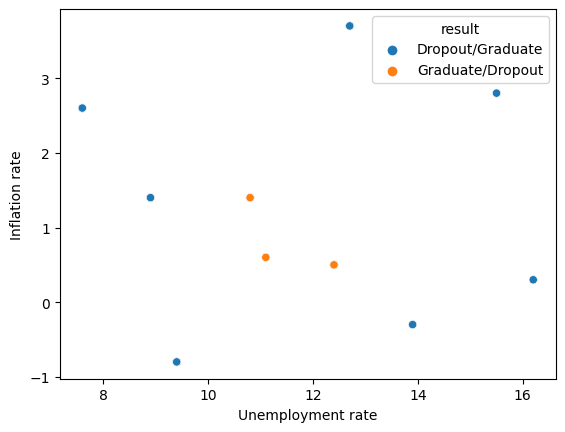

In [15]:
from seaborn import scatterplot
scatterplot(data=test_df[test_df['result'].isin({'Dropout/Graduate', 'Graduate/Dropout'})],
            x='Unemployment rate', y='Inflation rate', hue='result')

<Axes: xlabel='Curricular units 1st sem (grade)', ylabel='Curricular units 2nd sem (grade)'>

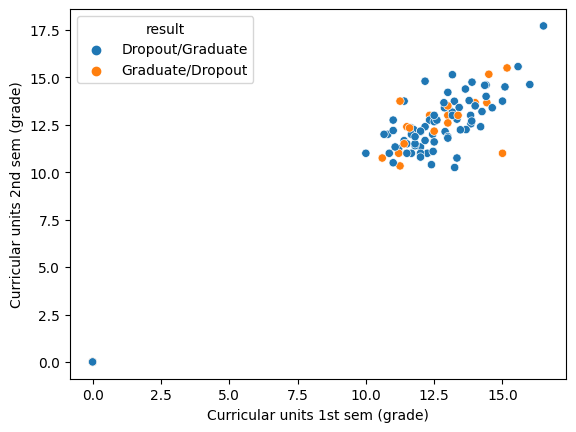

In [16]:
scatterplot(data=test_df[test_df['result'].isin({'Dropout/Graduate', 'Graduate/Dropout'})],
            x='Curricular units 1st sem (grade)', y='Curricular units 2nd sem (grade)', hue='result')

Let's do some dimension reduction.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1198 samples in 0.001s...
[t-SNE] Computed neighbors for 1198 samples in 0.251s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1198
[t-SNE] Computed conditional probabilities for sample 1198 / 1198
[t-SNE] Mean sigma: 6.008772
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.069836
[t-SNE] KL divergence after 1000 iterations: 0.684274


<Axes: xlabel='tsne_x', ylabel='tsne_y'>

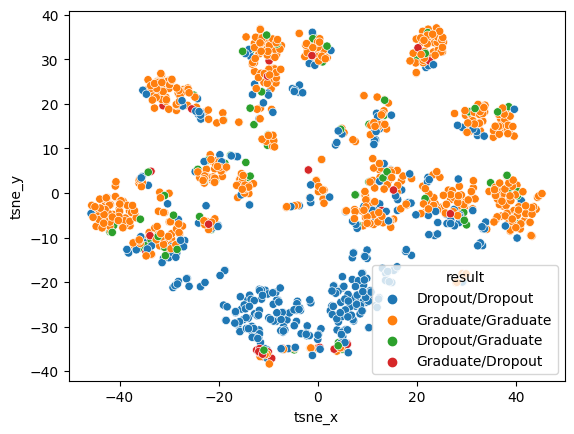

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', n_iter=1000,
            n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca',
            verbose=1, random_state=2023, method='barnes_hut', angle=0.5, n_jobs=None)
tsne_result = tsne.fit_transform(X=X_test)
test_df['tsne_x'] = tsne_result[:, 0]
test_df['tsne_y'] = tsne_result[:, 1]
scatterplot(data=test_df, x='tsne_x', y='tsne_y', hue='result')

<Axes: xlabel='tsne_x', ylabel='tsne_y'>

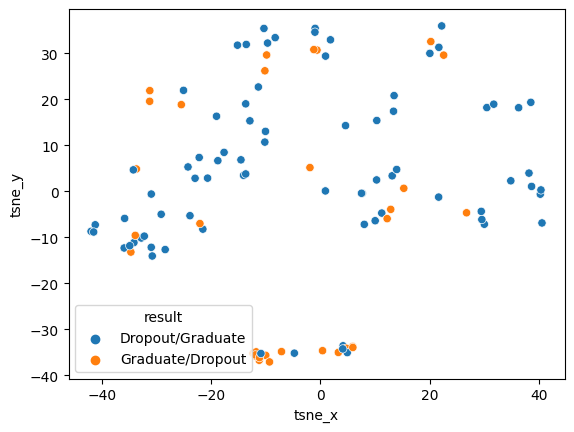

In [18]:
scatterplot(data=test_df[test_df['result'].isin({'Dropout/Graduate', 'Graduate/Dropout'})], x='tsne_x', y='tsne_y', hue='result')

Text(0, 0.5, 'Mean decrease in impurity')

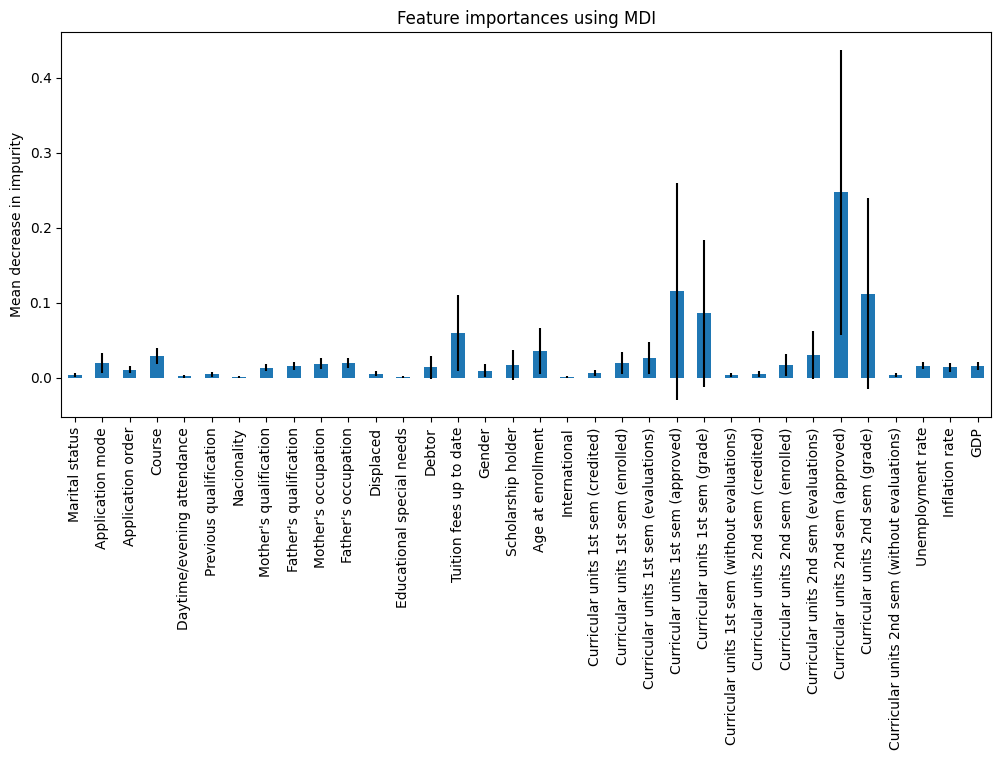

In [19]:
from numpy import std
forest_importances = pd.Series(model.feature_importances_, index=X_train.columns.tolist())
_, ax = subplots(figsize=(12, 5))
forest_importances.plot.bar(
    ax=ax,
    yerr=std([tree.feature_importances_ for tree in model.estimators_], axis=0), 
)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


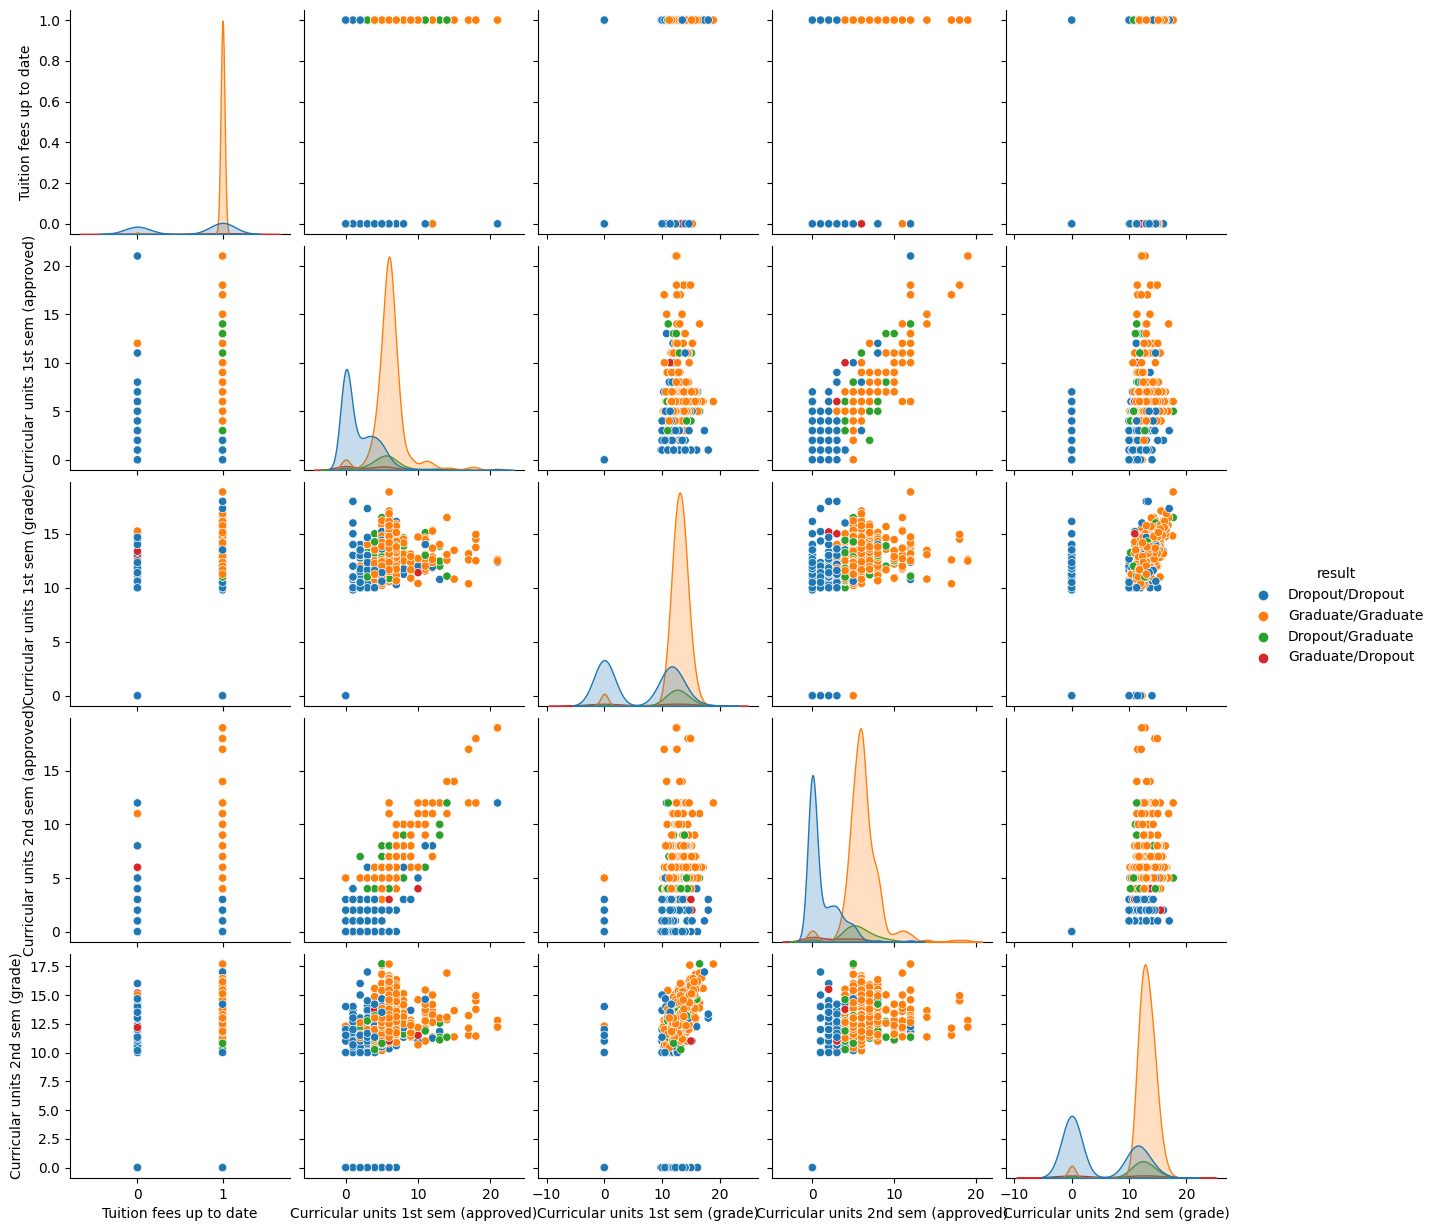

In [20]:
from seaborn import pairplot
pairplot_columns = ['Tuition fees up to date', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
                    'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'result']
pairplot(data=test_df[pairplot_columns], hue='result')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


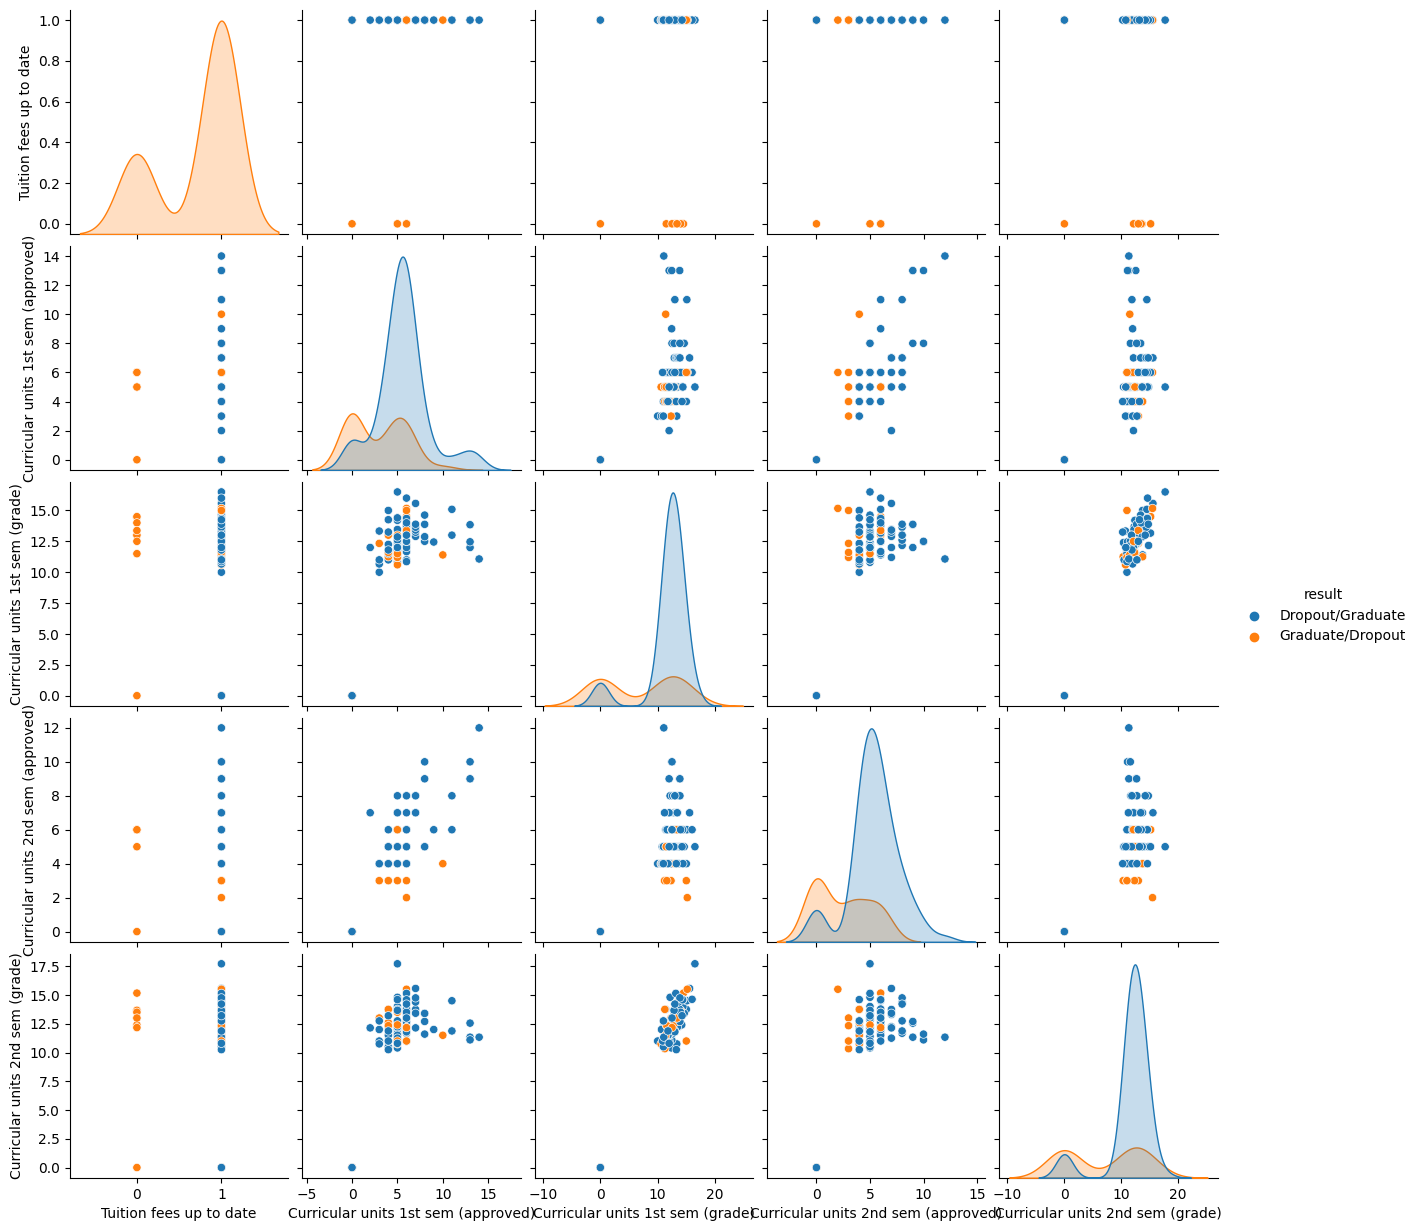

In [21]:
pairplot(data=test_df[test_df['result'].isin({'Dropout/Graduate', 'Graduate/Dropout'})][pairplot_columns], hue='result')